In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFECV, SelectFromModel, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import auc, roc_curve, f1_score
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
x_train = pd.read_csv("base_information_train.csv", index_col=0)
y_train = np.load("Alzheimer_label.npy")
gene_train = np.load("Gene_data_train.npy")
x_test = pd.read_csv("base_information_test.csv", index_col=0)
gene_test = np.load("Gene_data_test.npy")

In [3]:
df = x_train.copy()
df["Alzheimer"] = y_train

In [4]:
df.head()

,age,gender,height,weight,Alzheimer
0,74.0,0,157.0,45.0,1
1,66.0,0,156.0,60.0,0
2,80.0,1,174.0,78.0,0
3,69.0,0,162.0,55.0,1
4,79.0,0,177.0,49.0,0


In [5]:
df.isnull().sum()

age          0
gender       0
height       0
weight       0
Alzheimer    0
dtype: int64

In [6]:
x_test.isnull().sum()

age       0
gender    0
height    0
weight    0
dtype: int64

In [7]:
np.isnan(gene_train).sum()

0

In [8]:
np.isnan(gene_test).sum()

0

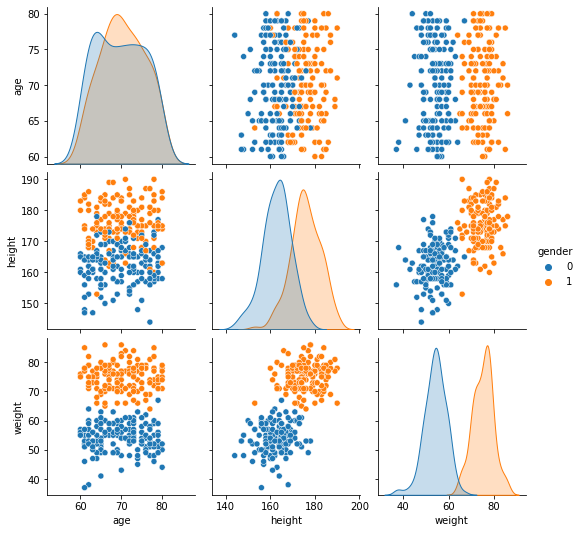

In [9]:
sns.pairplot(x_train, hue="gender")

<AxesSubplot:xlabel='Alzheimer', ylabel='count'>

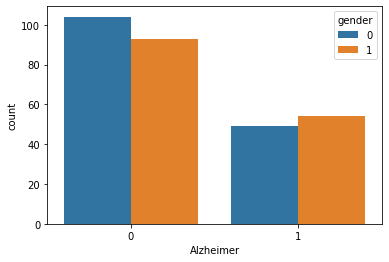

In [10]:
sns.countplot(x="Alzheimer", hue="gender", data=df)

In [11]:
sel1 = VarianceThreshold()
tmp1 = sel1.fit_transform(gene_train.reshape([gene_train.shape[0], -1]))
tmp1.shape

(300, 220000)

In [12]:
sel2 = SelectKBest(chi2, k=100)
tmp2 = sel2.fit_transform(tmp1, y_train)
sel2.get_feature_names_out()

array(['x2459', 'x15870', 'x17076', 'x17251', 'x17590', 'x17704',
       'x18510', 'x20011', 'x25672', 'x26624', 'x27344', 'x38696',
       'x41948', 'x42204', 'x45037', 'x45796', 'x48022', 'x53428',
       'x54853', 'x60629', 'x62335', 'x62362', 'x63340', 'x65023',
       'x65498', 'x66912', 'x71786', 'x73635', 'x73934', 'x74122',
       'x74472', 'x74533', 'x74995', 'x81345', 'x83700', 'x84234',
       'x86580', 'x86912', 'x88698', 'x89946', 'x90072', 'x96130',
       'x97115', 'x98257', 'x100360', 'x105846', 'x107553', 'x115067',
       'x115331', 'x116174', 'x117486', 'x118241', 'x118925', 'x120015',
       'x120864', 'x123419', 'x124343', 'x124421', 'x129003', 'x130489',
       'x131878', 'x131884', 'x132676', 'x133436', 'x134695', 'x139257',
       'x143604', 'x148060', 'x150222', 'x155553', 'x157235', 'x158029',
       'x159894', 'x160926', 'x161204', 'x162373', 'x167316', 'x168694',
       'x168695', 'x169299', 'x170657', 'x170865', 'x173804', 'x176074',
       'x176448', 'x179

In [13]:
sel3 = RFECV(estimator=LogisticRegression(), step=1, min_features_to_select=10, cv=5, n_jobs=-1)
tmp3 = sel3.fit_transform(tmp2, y_train)
tmp3.shape

(300, 88)

In [14]:
X_train = np.c_[x_train, tmp3]
sel4 = SelectFromModel(RandomForestClassifier(random_state=0), max_features=10)
X_train = sel4.fit_transform(X_train, y_train)
X_train[:5]

array([[ 74., 157.,  45.,   1.,   1.,   0.,   1.,   0.,   1.,   2.],
       [ 66., 156.,  60.,   0.,   0.,   0.,   0.,   0.,   1.,   0.],
       [ 80., 174.,  78.,   0.,   0.,   0.,   1.,   1.,   0.,   0.],
       [ 69., 162.,  55.,   1.,   1.,   0.,   0.,   1.,   0.,   1.],
       [ 79., 177.,  49.,   0.,   1.,   1.,   0.,   0.,   1.,   1.]])

In [15]:
xtrain, xtest, ytrain, ytest = train_test_split(X_train, y_train, train_size=0.8, random_state=0)

In [16]:
para = {"criterion":["gini", "entropy"], "max_features":["sqrt", "log2"], "max_depth":[3,4,5,6,7]}
rf = RandomForestClassifier(n_jobs=-1, random_state=0)
model = GridSearchCV(rf, para, scoring="accuracy", n_jobs=-1, cv=5, refit=True)
model.fit(xtrain, ytrain)
model.best_score_

0.7083333333333334

In [17]:
acc = model.score(xtest, ytest)
y_pred = model.predict_proba(xtest)[:, 1]
y_pred_lab = model.predict(xtest)
fpr, tpr, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(fpr, tpr)

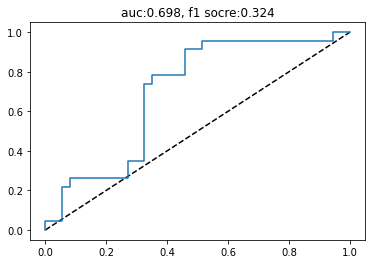

In [18]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title(f'auc:{roc_auc :.3f}, f1 socre:{f1_score(ytest, y_pred_lab) :.3f}')
plt.show()

In [19]:
pl1 = make_pipeline(sel1, sel2, sel3)
pl2 = make_pipeline(sel4, model)
X_train = np.c_[x_test, pl1.transform(gene_test.reshape([gene_test.shape[0], -1]))]
proba = pl2.predict_proba(X_train)
p_class = pl2.predict(X_train)
p_class

array([0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=int64)

In [20]:
proba

array([[0.67257955, 0.32742045],
       [0.49167808, 0.50832192],
       [0.87822443, 0.12177557],
       [0.84856126, 0.15143874],
       [0.77202388, 0.22797612],
       [0.40165201, 0.59834799],
       [0.63655021, 0.36344979],
       [0.81403347, 0.18596653],
       [0.38373205, 0.61626795],
       [0.86802014, 0.13197986],
       [0.42955443, 0.57044557],
       [0.82125149, 0.17874851],
       [0.67046943, 0.32953057],
       [0.64728749, 0.35271251],
       [0.33203528, 0.66796472],
       [0.79881199, 0.20118801],
       [0.8331636 , 0.1668364 ],
       [0.56332053, 0.43667947],
       [0.52080882, 0.47919118],
       [0.62955412, 0.37044588],
       [0.53022703, 0.46977297],
       [0.52120725, 0.47879275],
       [0.66273237, 0.33726763],
       [0.51271193, 0.48728807],
       [0.57179354, 0.42820646],
       [0.7475976 , 0.2524024 ],
       [0.80070728, 0.19929272],
       [0.92294181, 0.07705819],
       [0.83789696, 0.16210304],
       [0.61037454, 0.38962546],
       [0.

In [21]:
np.save("AD_Results.npy", proba[:, 1])